In [1]:
% pylab inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.contrib.kfac.python.ops.utils import fwd_gradients
import seaborn as sns
try:
    from moviepy.video.io.bindings import mplfig_to_npimage
    import moviepy.editor as mpy
    generate_movie = True
except:
    print("Warning: moviepy not found.")
    generate_movie = False

slim = tf.contrib.slim
ds = tf.contrib.distributions

Populating the interactive namespace from numpy and matplotlib


In [2]:
print(tf.__version__)

1.5.0-rc1



### Generator and discriminator architectures

(same architecture as proposed in google brain paper)


In [3]:
def generator(z, output_dim=2, n_hidden=384, n_layer=6):
    with tf.variable_scope("generator"):
        h = slim.stack(z, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        x = slim.fully_connected(h, output_dim, activation_fn=None)
    return x

def discriminator(x, n_hidden=384, n_layer=6, reuse=False):
    with tf.variable_scope("discriminator", reuse=reuse):
        h = slim.stack(x, slim.fully_connected, [n_hidden] * n_layer, activation_fn=tf.nn.relu)
        log_d = slim.fully_connected(h, 1, activation_fn=None)
    return log_d

### Data creation

In [4]:
def sample_mog(batch_size, n_mixture=16, std=0.2):
    x = np.linspace(-4.5,4.5,4)
    xs, ys = np.meshgrid(x, x)
    xs, ys = xs.flatten(), ys.flatten()
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)

In [5]:
def load_mnist_and_sample(batch_size):
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
    from sampler import sampler
    
    im=mnist.train.next_batch(1)[0]
    im=im.reshape([28,28])
    
    x = np.linspace(0, 1, 28)
    y = np.linspace(0, 1,28)
    xv, yv = np.meshgrid(x, y)
    z=im
    s=sampler(x,y,z)
    vals = s.sample(batch_size)
    
    return vals,im
    
def plot_vals_im(vals,im):
    xVals = []; yVals = []
    fig, ax = plt.subplots(nrows=1, ncols=2)
    for item in vals:  # plot point by point
            xVals.append(item[0])
            yVals.append(item[1])
            ax[0].plot(item[0], 1-item[1], marker="x", c="red")
            ax[0].set_title('Complex distribution')
    
    ax[1].imshow(im,cmap='gray')
    ax[1].set_title('Original Image')
    plt.show()

def sample_complex(batch_size):
    vals, im = load_mnist_and_sample(batch_size)
    plot_vals_im(vals,im)
    
    return tf.stack(vals)

### Hyperparam

In [6]:
params = dict(
    batch_size=512,
    disc_learning_rate=9e-5,
    gen_learning_rate=9e-5,
    beta1=0.5,
    epsilon=1e-8,
    max_iter=8000,
    frame_every=50, 
    viz_every=50,
    z_dim=256,
    x_dim=2,
    optimizer='consensus', # rmsprop sgd sga
    align = False,
    data = 'mog',
)

## Function for Symplectic gradient adjustment

In [7]:
def jac_vec(ys,xs,vs):
    return fwd_gradients(ys,xs,grad_xs=vs, stop_gradients=xs)

def jac_tran_vec(ys,xs,vs):
    dydxs = tf.gradients(ys,xs,grad_ys=vs, stop_gradients=xs)
    return [tf.zeros_like(x) if dydx is None else dydx for (x,dydx) in zip(xs,dydxs)]

def get_sym_adj(Ls,xs):
    xi= [tf.gradients(l,x)[0]for(l,x)in zip(Ls,xs)]
    H_xi = jac_vec(xi,xs,xi)
    Ht_xi = jac_tran_vec(xi,xs,xi)
    At_xi =[(ht-h)/2 for (h,ht) in zip(H_xi,Ht_xi)]
    return At_xi

## Construct model and training ops

In [8]:
tf.reset_default_graph()

data = sample_complex(params['batch_size']) if params['data']=='complex' else sample_mog(params['batch_size'])
noise = ds.Normal(tf.zeros(params['z_dim']), tf.ones(params['z_dim'])).sample(params['batch_size'])

# Construct generator and discriminator nets
with slim.arg_scope([slim.fully_connected], weights_initializer=tf.orthogonal_initializer(gain=1.4)):
    samples = generator(noise, output_dim=params['x_dim'])
    real_score = discriminator(data)
    fake_score = discriminator(samples, reuse=True)
    
# Saddle objective    
loss = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score, labels=tf.ones_like(real_score)) +
    tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score, labels=tf.zeros_like(fake_score)))

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator")

if params['optimizer'] == 'rmsprop':
    d_train_opt = tf.train.RMSPropOptimizer(params['gen_learning_rate'])
    g_train_opt = tf.train.RMSPropOptimizer(params['disc_learning_rate'])
    d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)
    
elif params['optimizer'] == 'sgd':    
    d_train_opt = tf.train.GradientDescentOptimizer(params['gen_learning_rate'])
    g_train_opt = tf.train.GradientDescentOptimizer(params['gen_learning_rate'])
    d_train_op = d_train_opt.minimize(loss, var_list=disc_vars)
    g_train_op = g_train_opt.minimize(-loss, var_list=gen_vars)
    
elif params['optimizer'] == 'sga': 
    d_opt = tf.train.RMSPropOptimizer(learning_rate=params['disc_learning_rate'])
    g_opt = tf.train.RMSPropOptimizer(learning_rate=params['gen_learning_rate'])

    dvs = d_opt.compute_gradients(loss, var_list=disc_vars)
    gvs = g_opt.compute_gradients(-loss, var_list=gen_vars)

    adj = get_sym_adj([loss]*len(disc_vars) + [-loss]*len(gen_vars),disc_vars+
                      gen_vars)
    d_adj= adj[:len(disc_vars)]
    g_adj = adj[-len(gen_vars)::]
    
    dvs_sga = [(grad + adj , var) for (grad,var),adj in zip(dvs,d_adj)]
    gvs_sga = [(grad + adj , var) for (grad,var),adj in zip(gvs,g_adj)]
    
    d_train_op = d_opt.apply_gradients(dvs_sga)
    g_train_op = g_opt.apply_gradients(gvs_sga)
    
elif params['optimizer'] == 'consensus': 
    
    d_opt = tf.train.RMSPropOptimizer(learning_rate=params['disc_learning_rate'])
    g_opt = tf.train.RMSPropOptimizer(learning_rate=params['gen_learning_rate'])

    dvs = d_opt.compute_gradients(loss, var_list=disc_vars)
    gvs = g_opt.compute_gradients(-loss, var_list=gen_vars)

    grads_d = [grad for (grad,var) in dvs]
    grads_g = [grad for (grad,var) in gvs]
    grads = grads_d + grads_g

    # Regularizer
    reg = 0.5 * sum(tf.reduce_sum(tf.square(g)) for g in grads)
    # Jacobian times gradiant
    variables = disc_vars + gen_vars
    Jgrads = tf.gradients(reg, variables)
    
    d_adj = Jgrads[:len(disc_vars)]
    g_adj = Jgrads[-len(gen_vars)::]
    
    dvs_sga = [(grad + adj , var) for (grad,var),adj in zip(dvs,d_adj)]
    gvs_sga = [(grad + adj , var) for (grad,var),adj in zip(gvs,g_adj)]
    
    d_train_op = d_opt.apply_gradients(dvs_sga)
    g_train_op = g_opt.apply_gradients(gvs_sga)

## Train

In [9]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

  0%|          | 0/8001 [00:00<?, ?it/s]

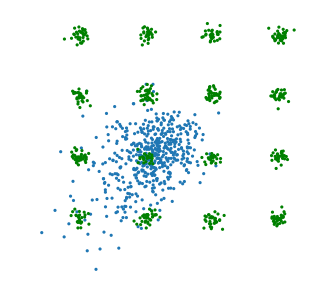

  1%|          | 50/8001 [00:01<09:41, 13.68it/s] 

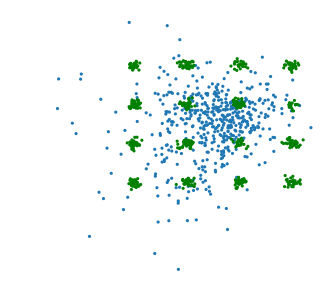

  1%|          | 99/8001 [00:02<02:43, 48.21it/s]

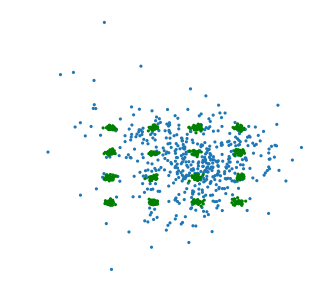

  2%|▏         | 148/8001 [00:03<02:04, 62.91it/s]

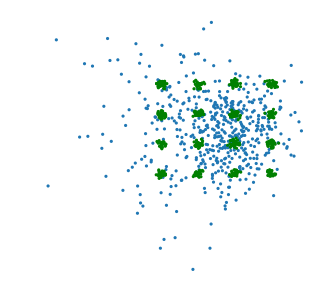

  2%|▏         | 199/8001 [00:04<01:59, 65.40it/s]

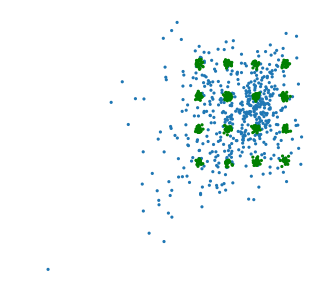

  3%|▎         | 248/8001 [00:04<01:58, 65.17it/s]

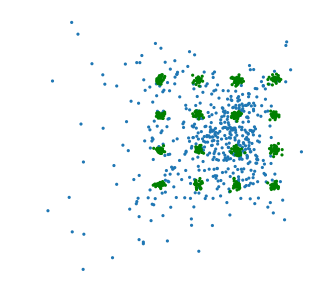

  4%|▎         | 297/8001 [00:05<01:59, 64.28it/s]

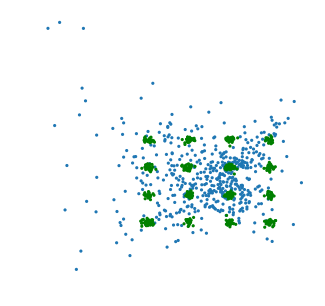

  4%|▍         | 346/8001 [00:06<01:59, 64.05it/s]

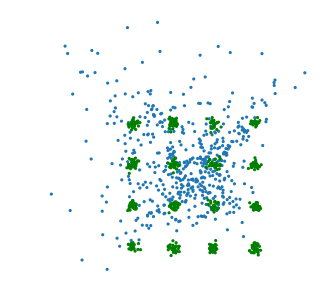

  5%|▍         | 395/8001 [00:07<02:01, 62.78it/s]

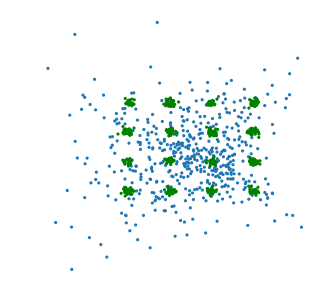

  6%|▌         | 445/8001 [00:08<01:57, 64.14it/s]

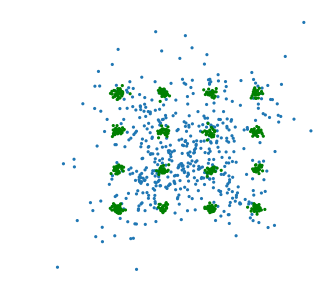

  6%|▌         | 494/8001 [00:09<01:58, 63.55it/s]

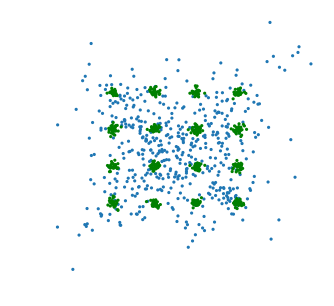

  7%|▋         | 550/8001 [00:10<01:52, 66.00it/s]

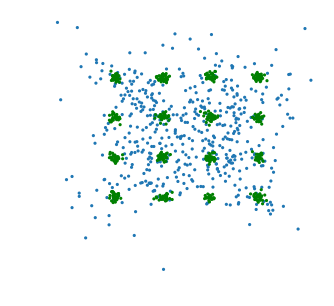

  7%|▋         | 599/8001 [00:10<01:53, 64.96it/s]

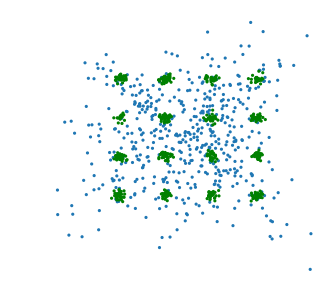

  8%|▊         | 649/8001 [00:12<02:02, 60.19it/s]

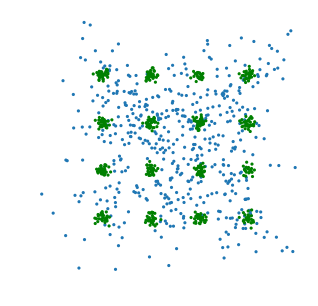

  9%|▊         | 698/8001 [00:12<01:54, 64.00it/s]

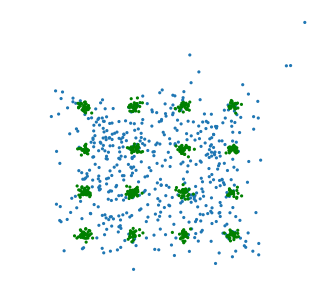

  9%|▉         | 748/8001 [00:13<01:52, 64.66it/s]

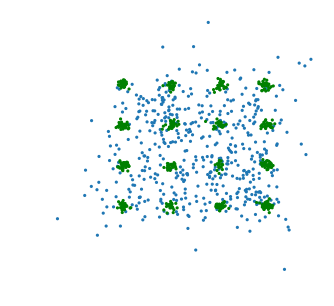

 10%|▉         | 799/8001 [00:14<01:49, 65.86it/s]

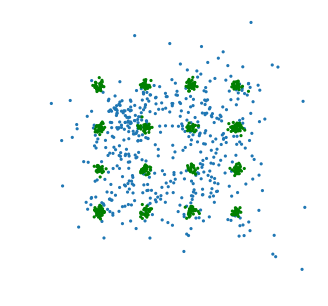

 11%|█         | 849/8001 [00:15<01:51, 64.29it/s]

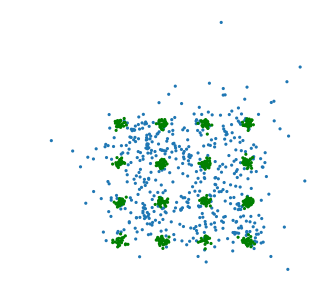

 11%|█         | 898/8001 [00:16<01:51, 63.82it/s]

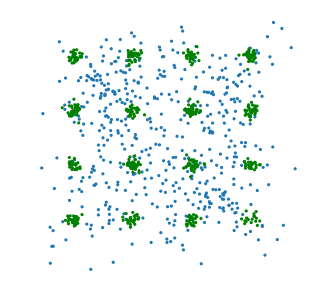

 12%|█▏        | 947/8001 [00:17<01:50, 63.87it/s]

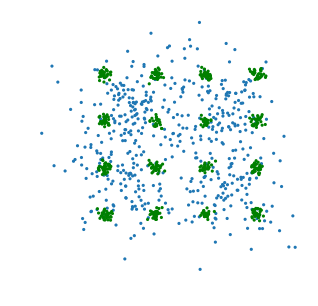

 12%|█▏        | 996/8001 [00:18<01:50, 63.20it/s]

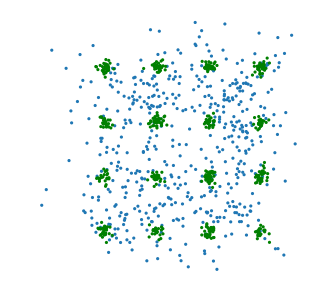

 13%|█▎        | 1046/8001 [00:18<01:47, 64.45it/s]

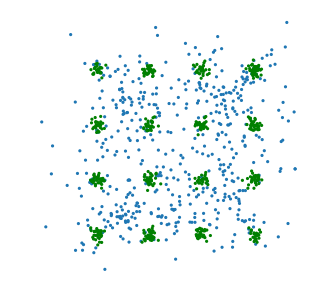

 14%|█▎        | 1095/8001 [00:19<01:47, 64.49it/s]

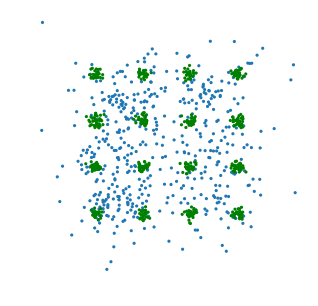

 14%|█▍        | 1144/8001 [00:20<01:45, 65.15it/s]

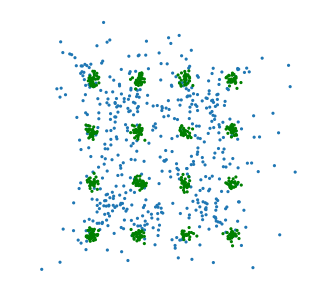

 15%|█▍        | 1194/8001 [00:21<01:44, 65.09it/s]

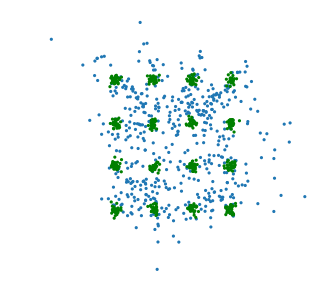

 16%|█▌        | 1250/8001 [00:22<01:44, 64.41it/s]

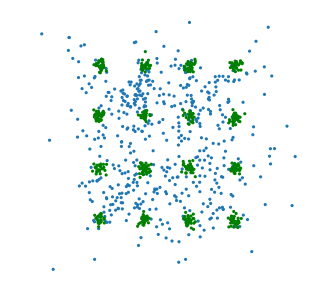

 16%|█▌        | 1300/8001 [00:23<01:45, 63.41it/s]

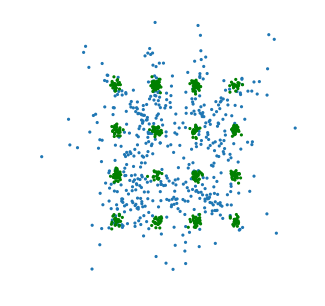

 17%|█▋        | 1349/8001 [00:24<01:43, 64.16it/s]

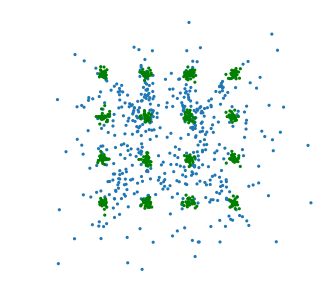

 17%|█▋        | 1398/8001 [00:25<01:41, 65.18it/s]

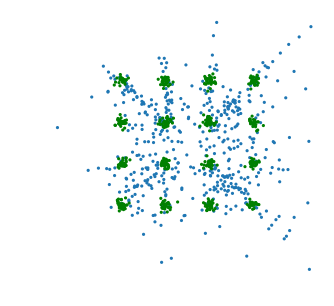

 18%|█▊        | 1447/8001 [00:25<01:41, 64.89it/s]

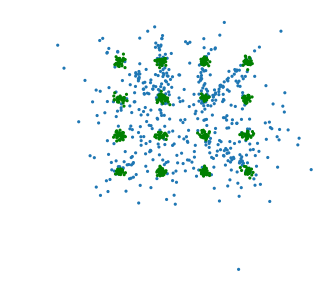

 19%|█▊        | 1496/8001 [00:26<01:40, 65.04it/s]

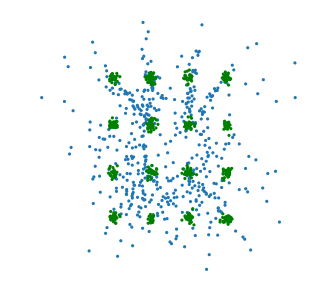

 19%|█▉        | 1545/8001 [00:27<01:43, 62.27it/s]

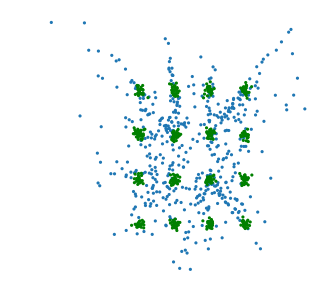

 20%|█▉        | 1594/8001 [00:28<01:41, 63.23it/s]

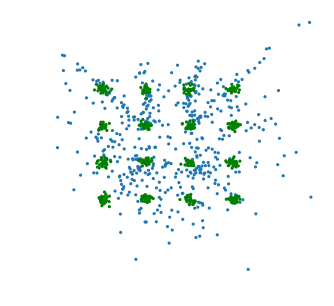

 21%|██        | 1650/8001 [00:29<01:37, 64.89it/s]

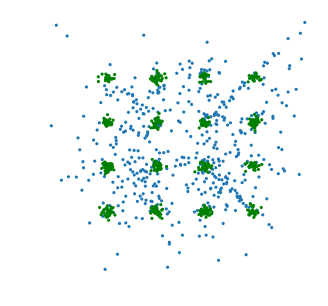

 21%|██        | 1699/8001 [00:30<01:37, 64.62it/s]

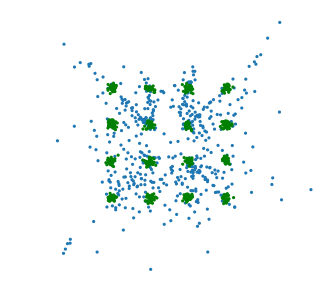

 22%|██▏       | 1748/8001 [00:31<01:37, 64.33it/s]

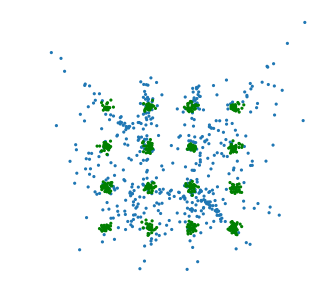

 22%|██▏       | 1797/8001 [00:32<01:36, 64.58it/s]

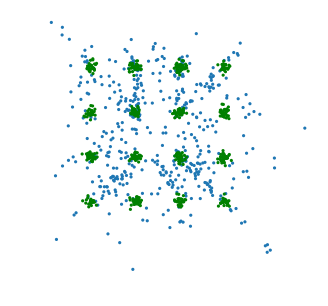

 23%|██▎       | 1846/8001 [00:32<01:38, 62.40it/s]

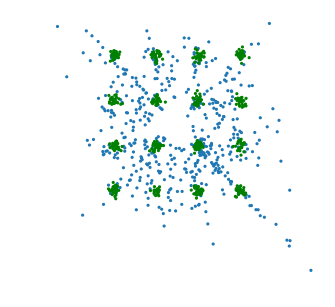

 24%|██▎       | 1895/8001 [00:33<01:36, 63.14it/s]

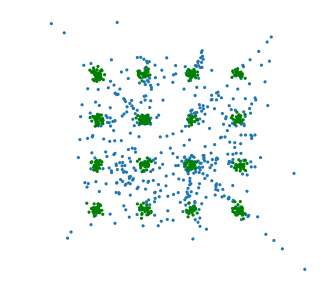

 24%|██▍       | 1944/8001 [00:34<01:36, 62.91it/s]

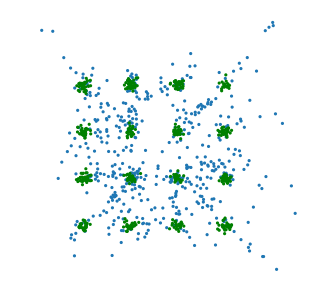

 25%|██▍       | 2000/8001 [00:35<01:34, 63.81it/s]

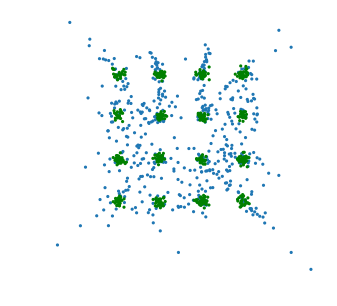

 26%|██▌       | 2049/8001 [00:36<01:32, 64.40it/s]

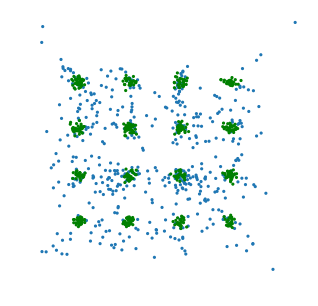

 26%|██▌       | 2098/8001 [00:37<01:34, 62.59it/s]

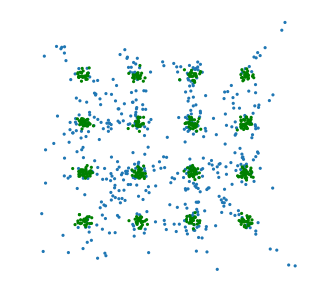

 27%|██▋       | 2148/8001 [00:38<01:31, 63.75it/s]

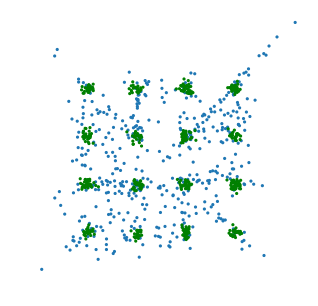

 27%|██▋       | 2197/8001 [00:39<01:30, 64.12it/s]

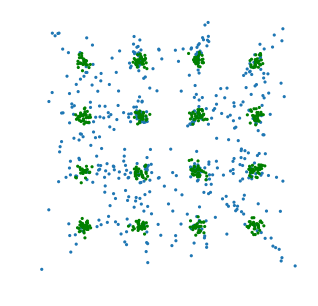

 28%|██▊       | 2246/8001 [00:39<01:30, 63.70it/s]

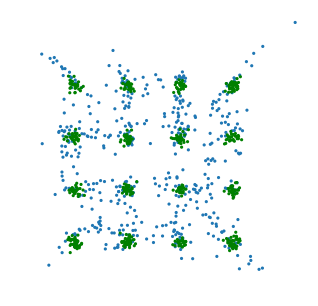

 29%|██▊       | 2295/8001 [00:40<01:28, 64.33it/s]

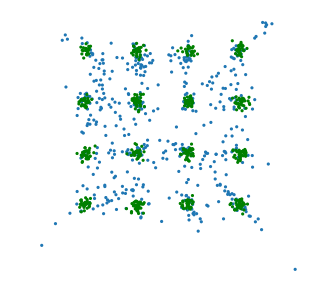

 29%|██▉       | 2344/8001 [00:41<01:28, 63.76it/s]

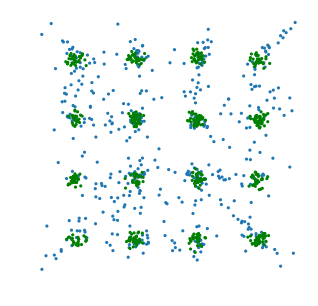

 30%|██▉       | 2394/8001 [00:42<01:26, 64.59it/s]

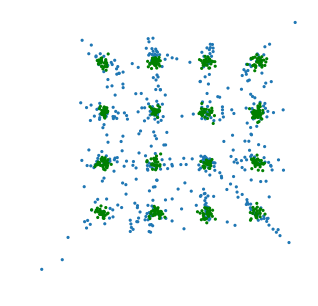

 31%|███       | 2444/8001 [00:43<01:25, 64.99it/s]

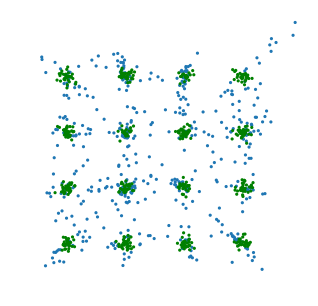

 31%|███       | 2500/8001 [00:44<01:27, 62.67it/s]

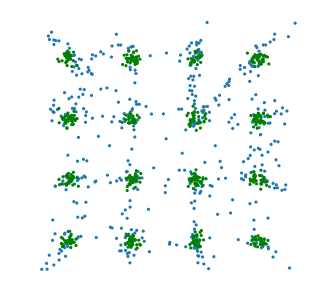

 32%|███▏      | 2549/8001 [00:45<01:25, 63.54it/s]

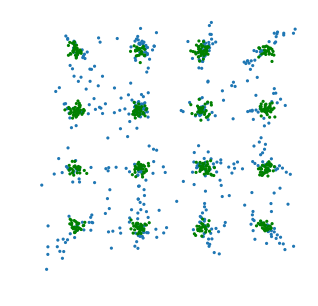

 32%|███▏      | 2599/8001 [00:46<01:23, 64.96it/s]

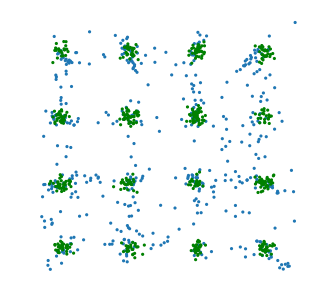

 33%|███▎      | 2649/8001 [00:46<01:23, 63.83it/s]

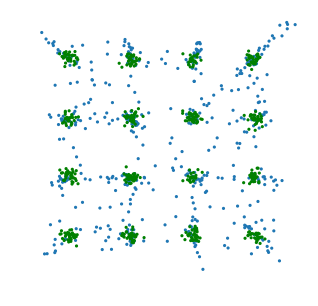

 34%|███▎      | 2698/8001 [00:47<01:23, 63.69it/s]

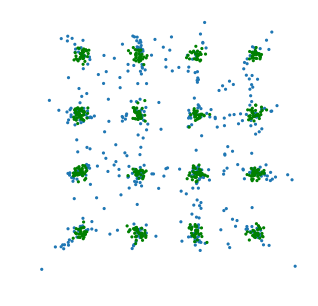

 34%|███▍      | 2747/8001 [00:48<01:30, 58.26it/s]

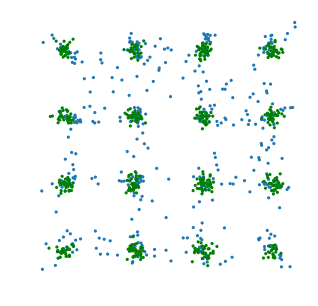

 35%|███▍      | 2796/8001 [00:49<01:24, 61.52it/s]

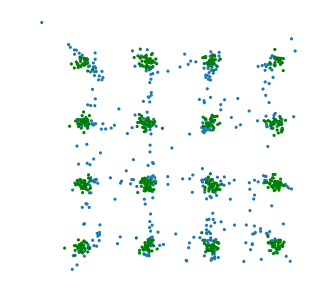

 36%|███▌      | 2846/8001 [00:50<01:22, 62.28it/s]

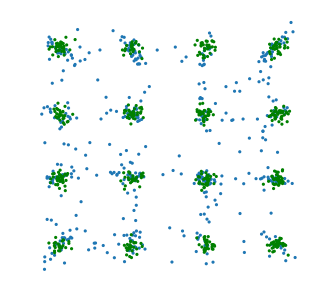

 36%|███▌      | 2895/8001 [00:51<01:19, 64.27it/s]

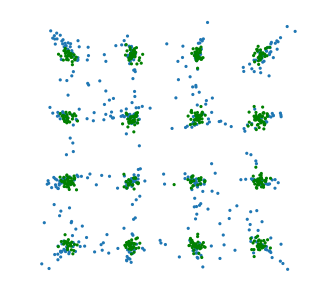

 37%|███▋      | 2944/8001 [00:52<01:18, 64.55it/s]

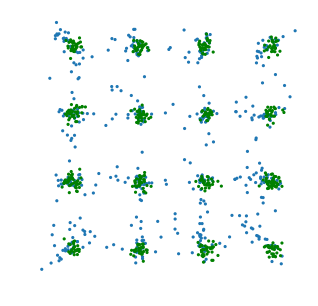

 37%|███▋      | 3000/8001 [00:53<01:19, 63.21it/s]

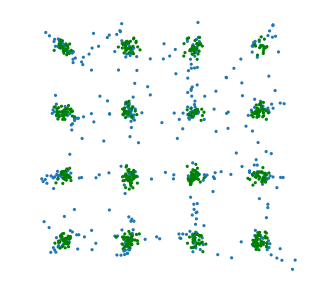

 38%|███▊      | 3050/8001 [00:54<01:18, 62.97it/s]

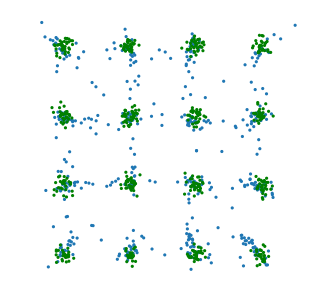

 39%|███▊      | 3099/8001 [00:55<01:16, 64.42it/s]

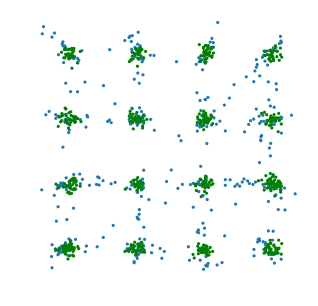

 39%|███▉      | 3148/8001 [00:55<01:17, 62.76it/s]

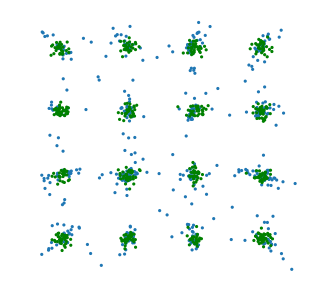

 40%|███▉      | 3197/8001 [00:56<01:14, 64.06it/s]

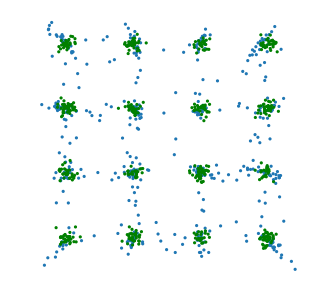

 41%|████      | 3247/8001 [00:57<01:13, 64.81it/s]

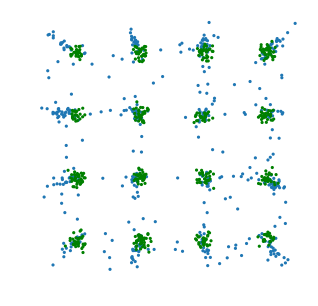

 41%|████      | 3296/8001 [00:58<01:13, 64.18it/s]

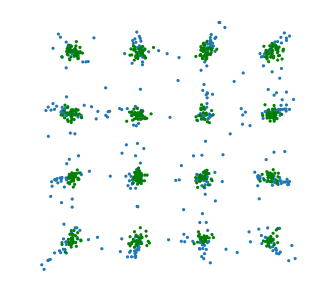

 42%|████▏     | 3345/8001 [00:59<01:13, 63.72it/s]

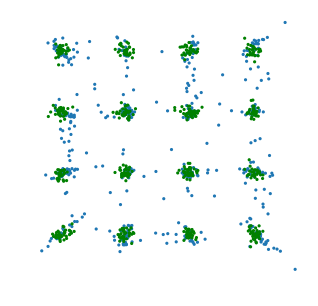

 42%|████▏     | 3394/8001 [01:00<01:10, 65.28it/s]

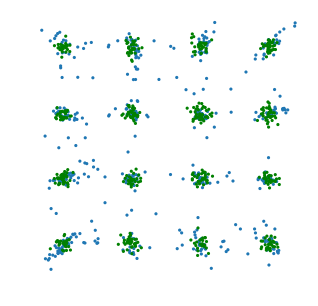

 43%|████▎     | 3444/8001 [01:01<01:10, 64.97it/s]

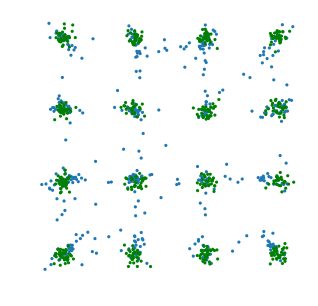

 44%|████▎     | 3500/8001 [01:01<01:09, 65.01it/s]

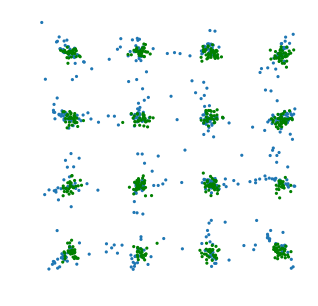

 44%|████▍     | 3550/8001 [01:02<01:09, 63.99it/s]

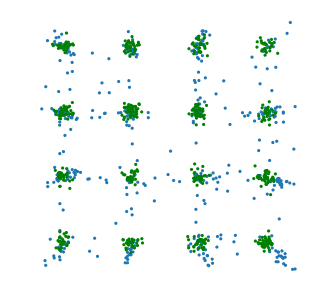

 45%|████▍     | 3599/8001 [01:03<01:07, 64.86it/s]

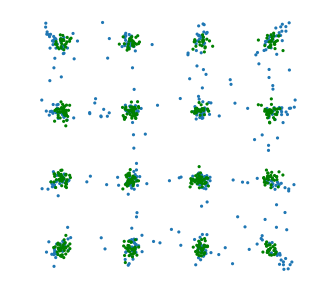

 46%|████▌     | 3648/8001 [01:04<01:07, 64.75it/s]

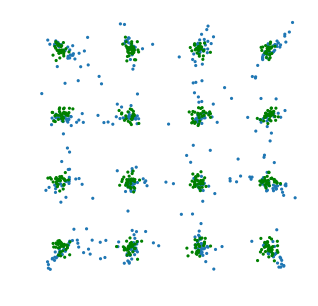

 46%|████▌     | 3697/8001 [01:05<01:06, 64.99it/s]

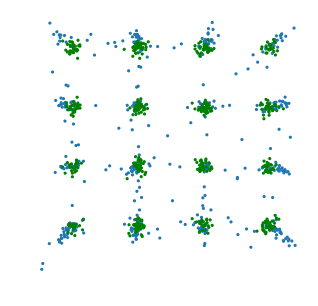

 47%|████▋     | 3747/8001 [01:06<01:05, 64.84it/s]

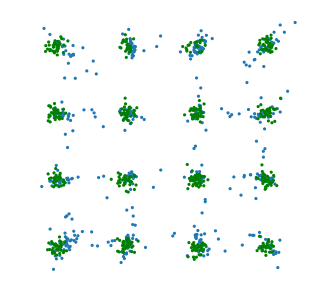

 47%|████▋     | 3796/8001 [01:07<01:06, 62.95it/s]

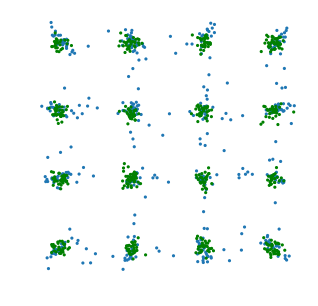

 48%|████▊     | 3846/8001 [01:07<01:05, 63.25it/s]

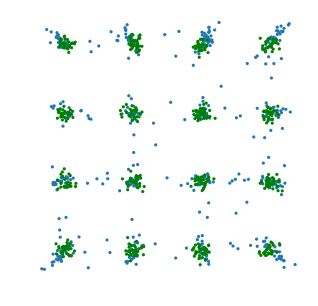

 49%|████▊     | 3895/8001 [01:08<01:04, 63.24it/s]

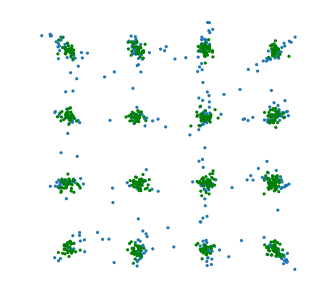

 49%|████▉     | 3944/8001 [01:09<01:04, 63.27it/s]

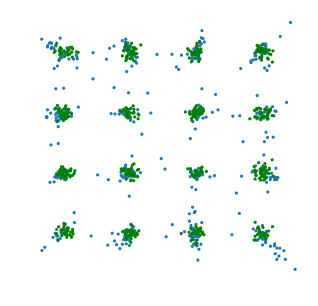

 50%|████▉     | 4000/8001 [01:10<01:01, 64.87it/s]

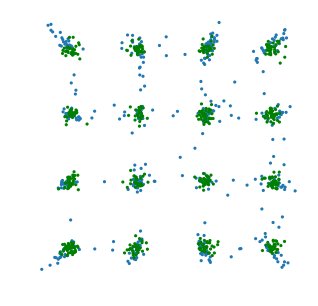

 51%|█████     | 4049/8001 [01:11<01:00, 65.16it/s]

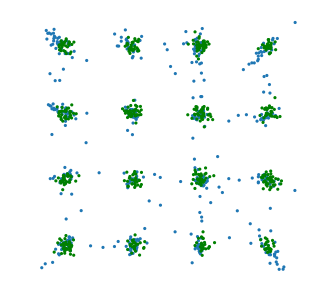

 51%|█████     | 4100/8001 [01:12<01:00, 64.84it/s]

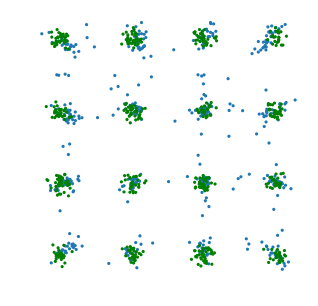

 52%|█████▏    | 4149/8001 [01:13<00:59, 64.78it/s]

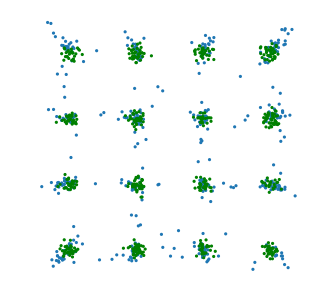

 52%|█████▏    | 4198/8001 [01:14<00:59, 63.70it/s]

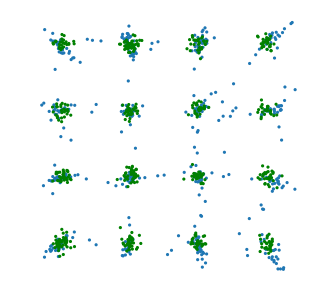

 53%|█████▎    | 4247/8001 [01:14<00:59, 62.84it/s]

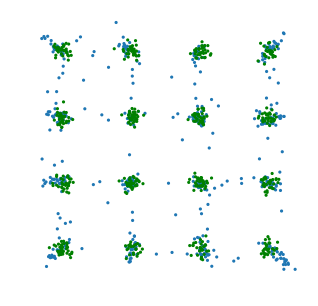

 54%|█████▎    | 4296/8001 [01:15<00:57, 64.12it/s]

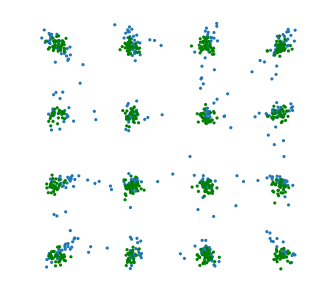

 54%|█████▍    | 4345/8001 [01:16<00:57, 64.09it/s]

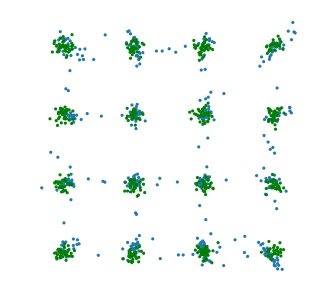

 55%|█████▍    | 4394/8001 [01:17<00:56, 63.66it/s]

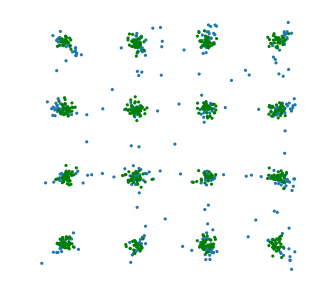

 56%|█████▌    | 4450/8001 [01:18<00:55, 64.38it/s]

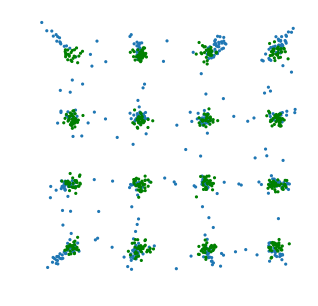

 56%|█████▌    | 4499/8001 [01:19<00:54, 64.67it/s]

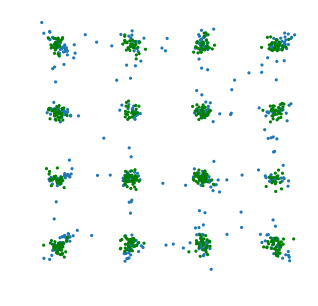

 57%|█████▋    | 4548/8001 [01:20<00:54, 63.15it/s]

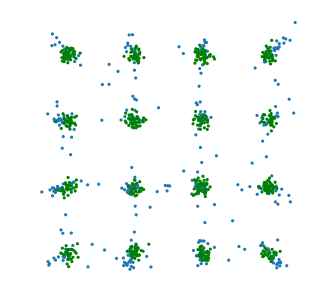

 57%|█████▋    | 4597/8001 [01:21<00:53, 64.22it/s]

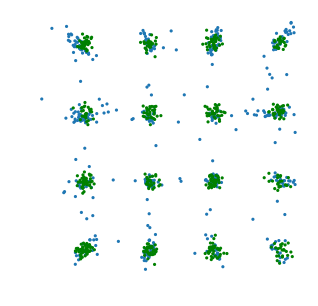

 58%|█████▊    | 4646/8001 [01:21<00:53, 62.16it/s]

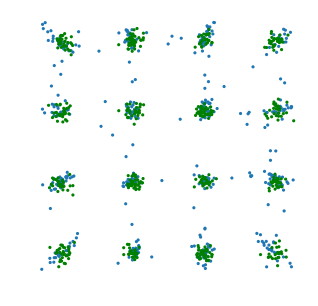

 59%|█████▊    | 4695/8001 [01:22<00:52, 63.18it/s]

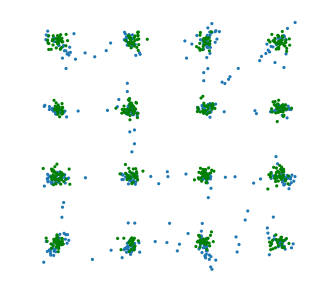

 59%|█████▉    | 4744/8001 [01:23<00:51, 63.78it/s]

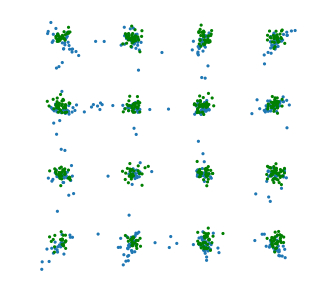

 60%|█████▉    | 4800/8001 [01:24<00:49, 64.61it/s]

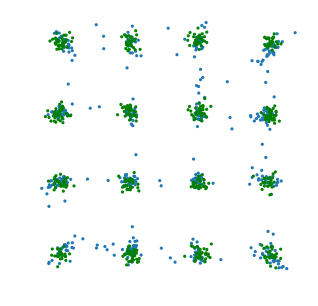

 61%|██████    | 4849/8001 [01:25<00:48, 65.34it/s]

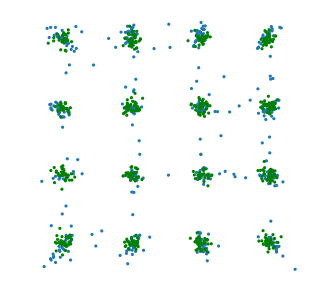

 61%|██████    | 4898/8001 [01:26<00:49, 62.25it/s]

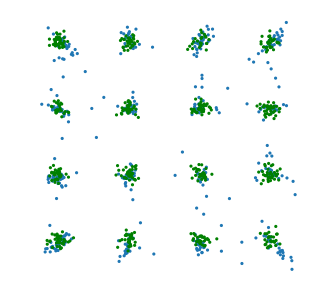

 62%|██████▏   | 4947/8001 [01:27<00:48, 63.58it/s]

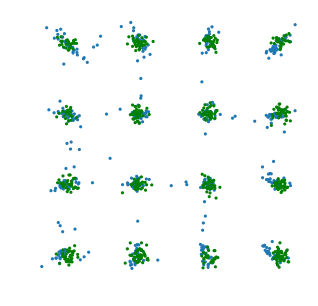

 62%|██████▏   | 4996/8001 [01:28<00:50, 59.50it/s]

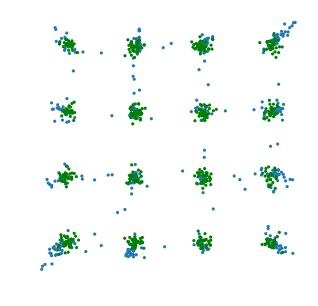

 63%|██████▎   | 5046/8001 [01:29<00:46, 64.22it/s]

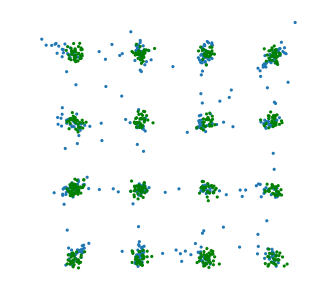

 64%|██████▎   | 5096/8001 [01:29<00:46, 62.28it/s]

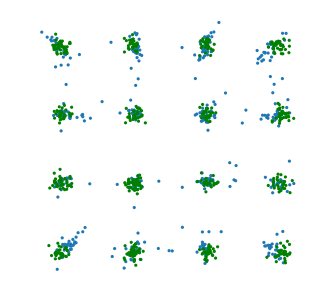

 64%|██████▍   | 5146/8001 [01:30<00:45, 63.18it/s]

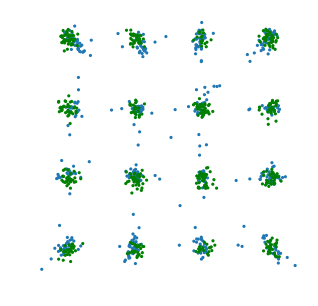

 65%|██████▍   | 5195/8001 [01:31<00:44, 63.25it/s]

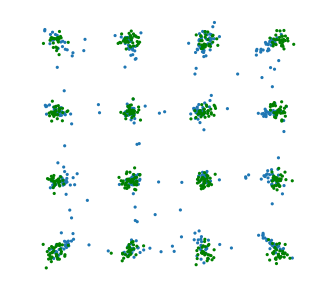

 66%|██████▌   | 5244/8001 [01:32<00:42, 64.77it/s]

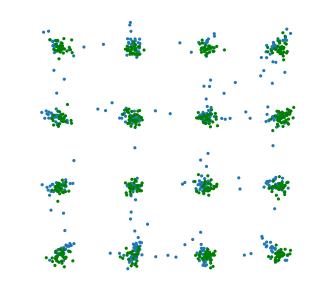

 66%|██████▌   | 5300/8001 [01:33<00:42, 64.10it/s]

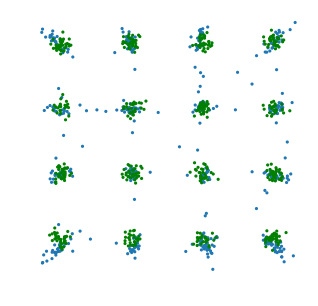

 67%|██████▋   | 5350/8001 [01:34<00:40, 64.95it/s]

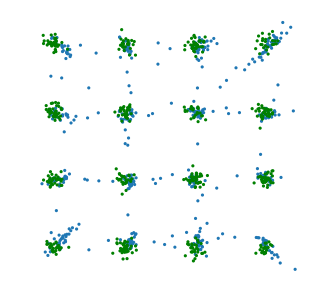

 67%|██████▋   | 5399/8001 [01:35<00:40, 63.62it/s]

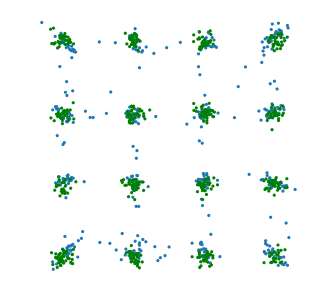

 68%|██████▊   | 5448/8001 [01:36<00:40, 63.67it/s]

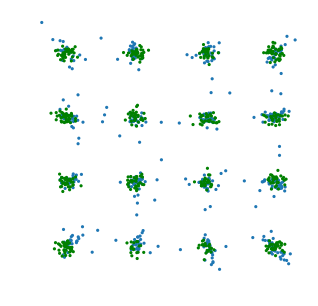

 69%|██████▊   | 5498/8001 [01:36<00:39, 63.47it/s]

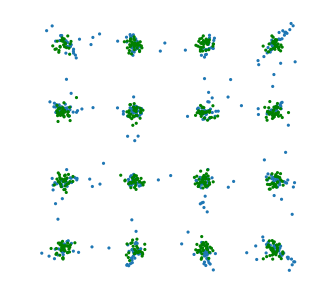

 69%|██████▉   | 5547/8001 [01:37<00:38, 64.42it/s]

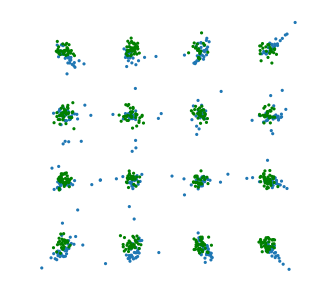

 70%|██████▉   | 5597/8001 [01:38<00:37, 63.80it/s]

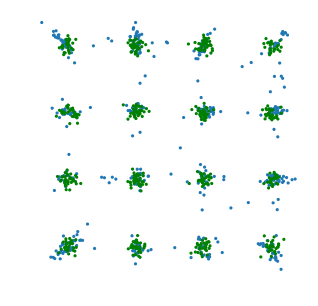

 71%|███████   | 5646/8001 [01:39<00:36, 64.38it/s]

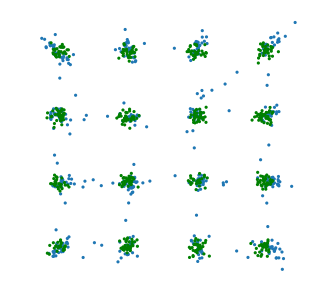

 71%|███████   | 5695/8001 [01:40<00:36, 63.93it/s]

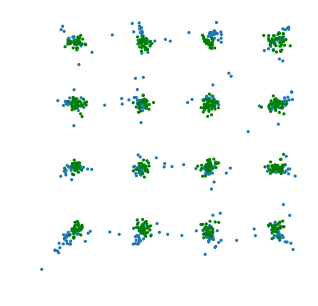

 72%|███████▏  | 5744/8001 [01:41<00:34, 64.56it/s]

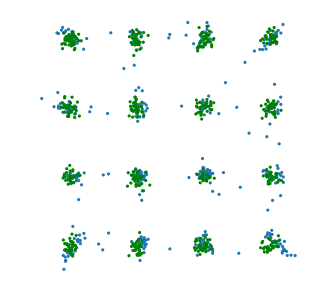

 72%|███████▏  | 5800/8001 [01:42<00:34, 63.44it/s]

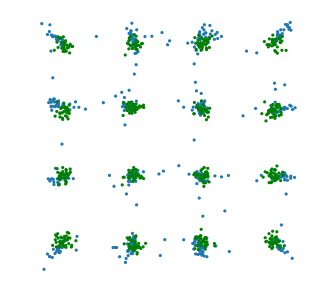

 73%|███████▎  | 5849/8001 [01:42<00:34, 62.09it/s]

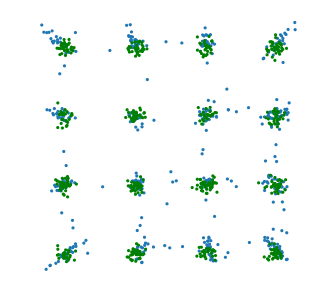

 74%|███████▎  | 5899/8001 [01:43<00:32, 64.41it/s]

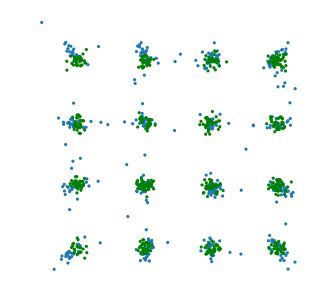

 74%|███████▍  | 5948/8001 [01:44<00:31, 64.36it/s]

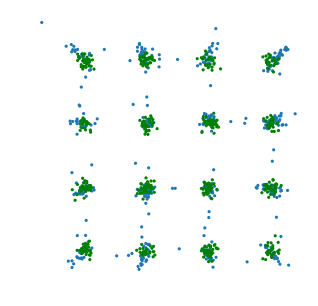

 75%|███████▍  | 5997/8001 [01:45<00:31, 63.05it/s]

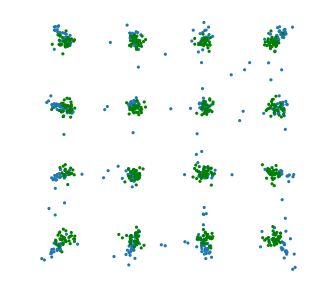

 76%|███████▌  | 6046/8001 [01:46<00:30, 63.32it/s]

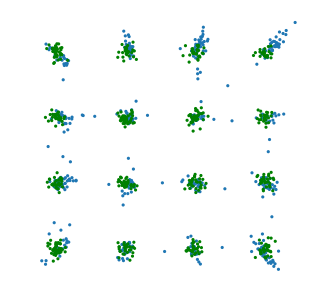

 76%|███████▌  | 6095/8001 [01:47<00:29, 63.79it/s]

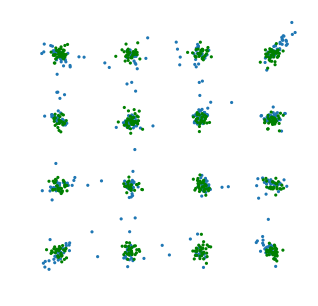

 77%|███████▋  | 6144/8001 [01:48<00:28, 64.21it/s]

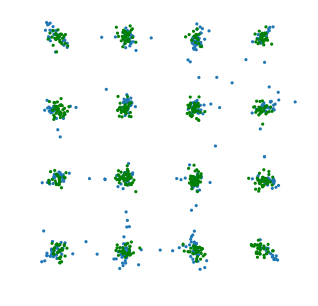

 77%|███████▋  | 6200/8001 [01:49<00:28, 63.61it/s]

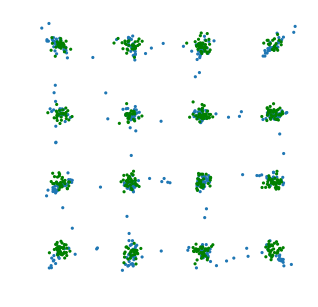

 78%|███████▊  | 6249/8001 [01:49<00:27, 64.31it/s]

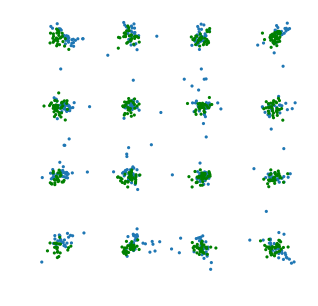

 79%|███████▊  | 6298/8001 [01:50<00:26, 63.62it/s]

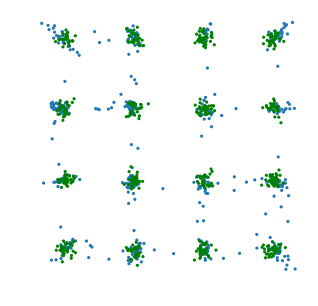

 79%|███████▉  | 6347/8001 [01:51<00:25, 64.24it/s]

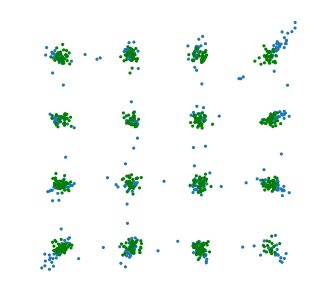

 80%|███████▉  | 6396/8001 [01:52<00:24, 64.44it/s]

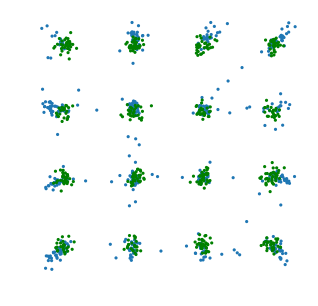

 81%|████████  | 6445/8001 [01:53<00:24, 63.27it/s]

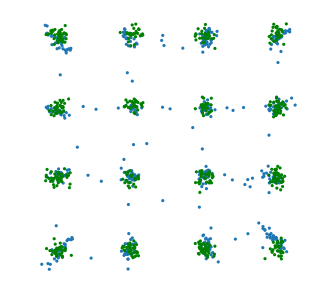

 81%|████████  | 6494/8001 [01:54<00:23, 64.73it/s]

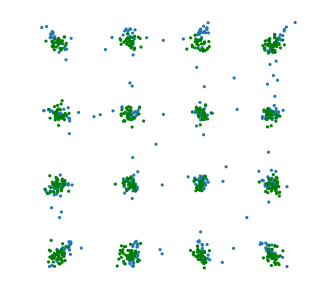

 82%|████████▏ | 6550/8001 [01:55<00:22, 64.26it/s]

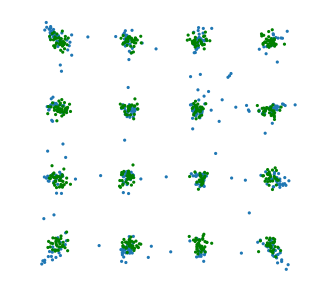

 82%|████████▏ | 6599/8001 [01:55<00:21, 64.00it/s]

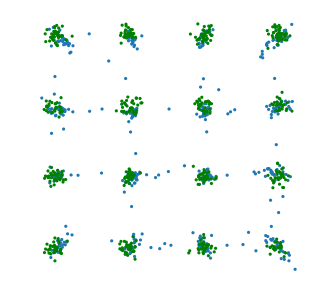

 83%|████████▎ | 6648/8001 [01:56<00:21, 63.00it/s]

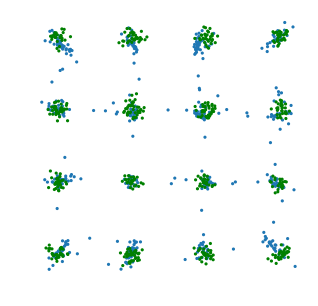

 84%|████████▎ | 6697/8001 [01:57<00:19, 65.41it/s]

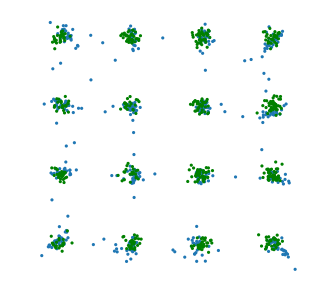

 84%|████████▍ | 6747/8001 [01:58<00:19, 65.62it/s]

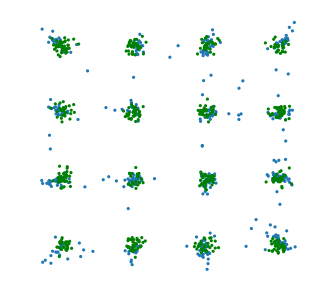

 85%|████████▍ | 6796/8001 [01:59<00:18, 64.23it/s]

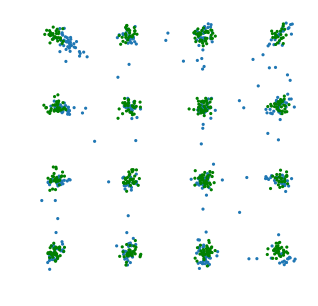

 86%|████████▌ | 6845/8001 [02:00<00:17, 64.97it/s]

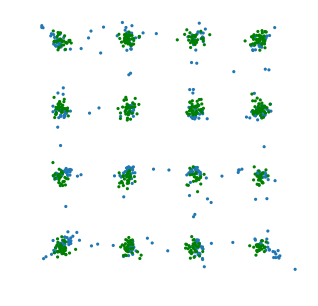

 86%|████████▌ | 6894/8001 [02:01<00:17, 63.66it/s]

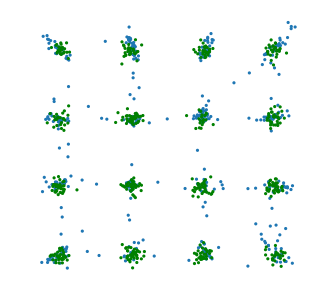

 87%|████████▋ | 6950/8001 [02:02<00:16, 64.45it/s]

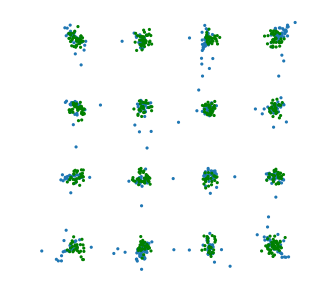

 87%|████████▋ | 7000/8001 [02:02<00:15, 64.71it/s]

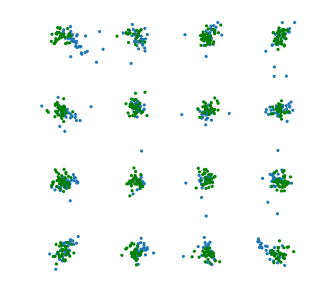

 88%|████████▊ | 7049/8001 [02:03<00:14, 64.75it/s]

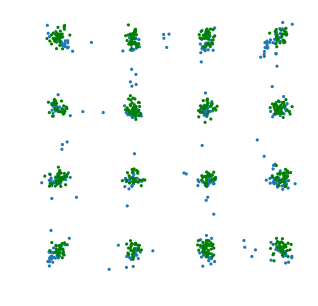

 89%|████████▊ | 7099/8001 [02:04<00:13, 66.05it/s]

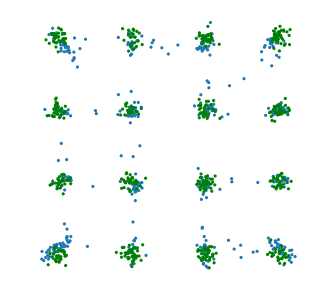

 89%|████████▉ | 7148/8001 [02:05<00:13, 63.97it/s]

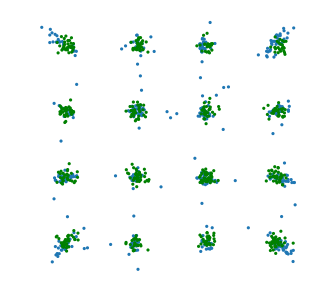

 90%|████████▉ | 7197/8001 [02:06<00:12, 64.78it/s]

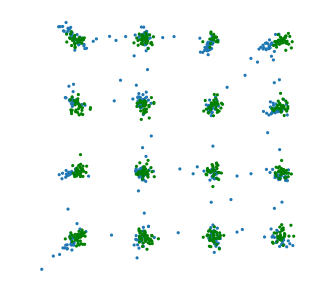

 91%|█████████ | 7246/8001 [02:07<00:12, 62.85it/s]

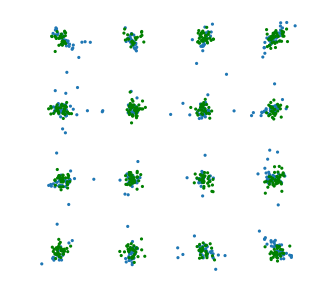

 91%|█████████ | 7295/8001 [02:07<00:11, 63.85it/s]

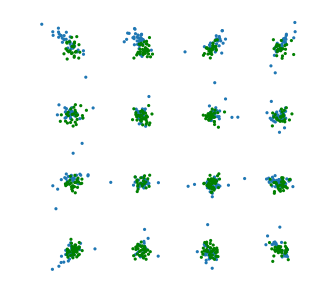

 92%|█████████▏| 7344/8001 [02:09<00:10, 59.81it/s]

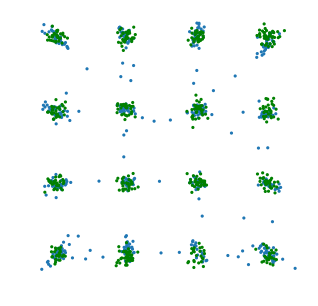

 92%|█████████▏| 7394/8001 [02:09<00:09, 65.07it/s]

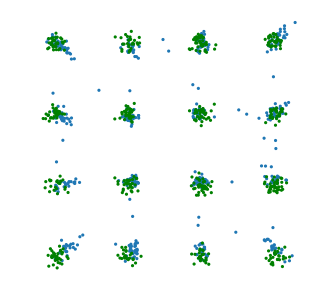

 93%|█████████▎| 7450/8001 [02:10<00:08, 65.69it/s]

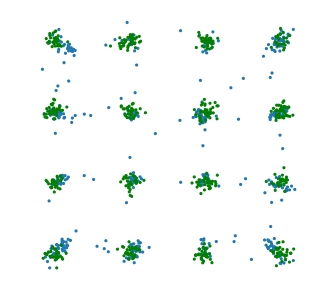

 94%|█████████▎| 7499/8001 [02:11<00:08, 62.67it/s]

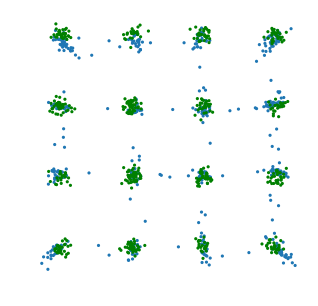

 94%|█████████▍| 7548/8001 [02:12<00:07, 62.98it/s]

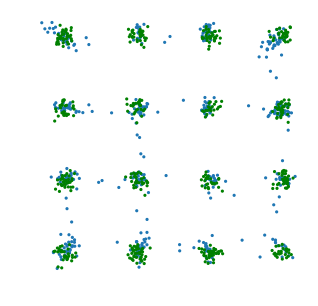

 95%|█████████▍| 7597/8001 [02:13<00:06, 62.63it/s]

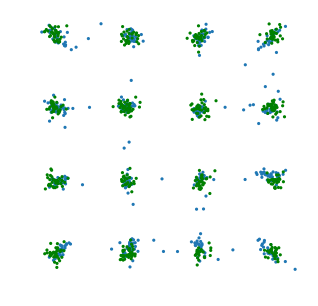

 96%|█████████▌| 7646/8001 [02:14<00:05, 63.75it/s]

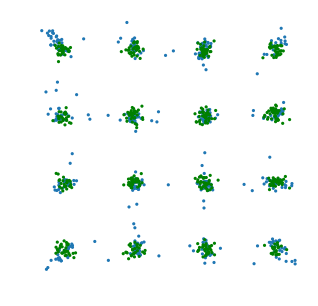

 96%|█████████▌| 7695/8001 [02:15<00:04, 63.47it/s]

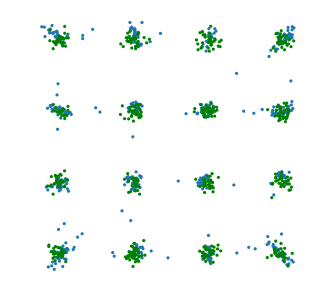

 97%|█████████▋| 7745/8001 [02:15<00:03, 65.14it/s]

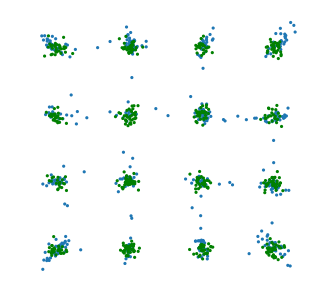

 97%|█████████▋| 7794/8001 [02:16<00:03, 64.35it/s]

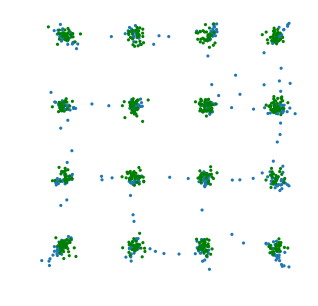

 98%|█████████▊| 7850/8001 [02:17<00:02, 63.03it/s]

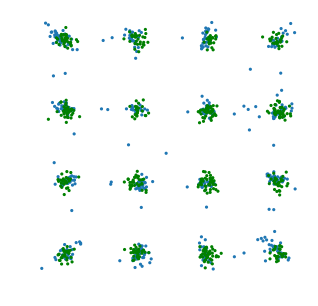

 99%|█████████▊| 7900/8001 [02:18<00:01, 63.83it/s]

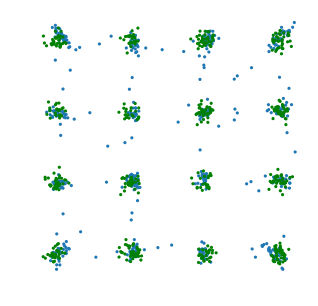

 99%|█████████▉| 7949/8001 [02:19<00:00, 64.48it/s]

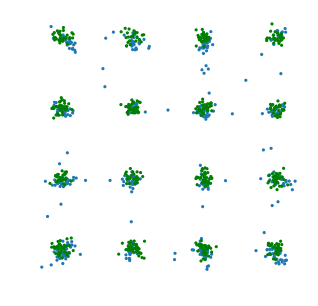

100%|█████████▉| 7998/8001 [02:20<00:00, 63.91it/s]

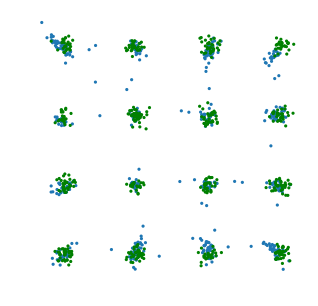

100%|██████████| 8001/8001 [02:20<00:00, 56.93it/s]


In [10]:
xmax = 3
fs = []
raw_frames = []
np_samples = []
n_batches_viz = 10
viz_every = params['viz_every']
frame_every = params['frame_every']
for i in tqdm(range(params['max_iter']+1)):
    f, _, _ = sess.run([[loss], g_train_op, d_train_op])
    fs.append(f)
    if (i) % frame_every == 0:
        np_samples.append(np.vstack([sess.run(samples) for _ in range(n_batches_viz)]))
        xx, yy = sess.run([samples, data])
#         print(sess.run(lambd))
        fig = figure(figsize=(5,5))
        scatter(xx[:, 0], xx[:, 1], edgecolor='none',s=10)
        scatter(yy[:, 0], yy[:, 1], c='g', edgecolor='none',s=10)
        if params["data"]=="complex":
            plt.xlim([-0.2, 1.2])
            plt.ylim([-0.2, 1.2])
#         else:
#             plt.xlim([-5.5, 5.5])
#             plt.ylim([-5.5, 5.5])
        axis('off')
        if generate_movie:
            raw_frames.append(mplfig_to_npimage(fig))
        if (i) % viz_every == 0:
            show()

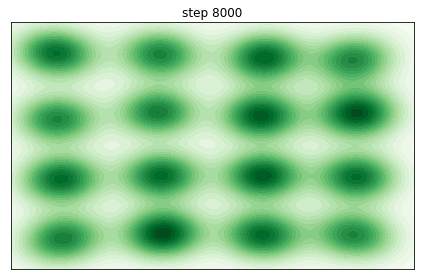

In [11]:
np_samples_ = np_samples[::1]
vizu_frames = []
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
# figure(figsize=(2*cols, 2))
fig, ax = plt.subplots()
for i, samps in enumerate(np_samples_):
    ax.clear()
#     if i == 0:
#         ax = subplot(1,cols,1)
#     else:
#         subplot(1,cols,i+1, sharex=ax, sharey=ax)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-6,6]]*2)
    ax2.set_axis_bgcolor(bg_color)
    xticks([]); yticks([])
    title('step %d'%(i*frame_every))
    if generate_movie:
        vizu_frames.append(mplfig_to_npimage(fig))
gcf().tight_layout()

## Video maker

In [12]:
raw_clip = mpy.ImageSequenceClip(raw_frames[::], fps=10)
raw_clip.write_videofile("raw_optimizer{}_{}.webm".format(params['optimizer'], params['data']), audio=False)
vizu_clip = mpy.ImageSequenceClip(vizu_frames[::], fps=10)
vizu_clip.write_videofile("vizu_optimizer{}_{}.webm".format(params['optimizer'], params['data']), audio=False)

[MoviePy] >>>> Building video raw_optimizerconsensus_mog.webm
[MoviePy] Writing video raw_optimizerconsensus_mog.webm


100%|██████████| 161/161 [00:04<00:00, 35.52it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: raw_optimizerconsensus_mog.webm 

[MoviePy] >>>> Building video vizu_optimizerconsensus_mog.webm
[MoviePy] Writing video vizu_optimizerconsensus_mog.webm



100%|██████████| 161/161 [00:05<00:00, 30.66it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: vizu_optimizerconsensus_mog.webm 

